In [1]:
pip install tensorflow-addons

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow==2.9.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Activation, ReLU, Conv2D, Add, GlobalMaxPool2D, GlobalAveragePooling2D, MaxPool2D, Flatten, Softmax, Cropping2D, Lambda, BatchNormalization as BatchNorm, Reshape, LeakyReLU, Conv2DTranspose, PReLU, RandomZoom
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

import numpy as np
from itertools import islice
from matplotlib import pyplot as plt
import multiprocessing as mp
import pandas as pd
import os
import datetime
import sklearn.model_selection

import tensorflow_addons as tfa

In [4]:
!nvidia-smi

Tue Oct  4 13:31:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   51C    P0    83W / 250W |  26993MiB / 40960MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def res_unit1(inp, a, b, block_id, layer_id, activation="elu",):
    Nonlinearity = lambda name: Activation(activation=activation, name=name)

    bn1 = BatchNorm(name=f"{block_id}/{layer_id}/bn1")(inp)
    elu1 = Nonlinearity(name=f"{block_id}/{layer_id}/activation1")(bn1)
    conv1 = Conv2D(filters=a, kernel_size=(1,1), name=f"{block_id}/{layer_id}/conv1")(elu1)

    bn2 = BatchNorm(name=f"{block_id}/{layer_id}/bn2")(conv1)
    elu2 = Nonlinearity(name=f"{block_id}/{layer_id}/activation2")(bn2)
    conv2 = Conv2D(filters=a, kernel_size=(3,3), padding="same", name=f"{block_id}/{layer_id}/conv2")(elu2)

    bn3 = BatchNorm(name=f"{block_id}/{layer_id}/bn3")(conv2)
    elu3 = Nonlinearity(name=f"{block_id}/{layer_id}/activation3")(bn3)
    conv3 = Conv2D(filters=b, kernel_size=(1,1), name=f"{block_id}/{layer_id}/conv3")(elu3)

    return Add(name=f"{block_id}/{layer_id}/add")([inp, conv3])

def res_unit2(inp, a, b, block_id, layer_id, activation="elu"):
    Nonlinearity = lambda name: Activation(activation=activation, name=name)

    bn = BatchNorm(name=f"{block_id}/{layer_id}/bn0")(inp)
    elu = Nonlinearity(name=f"{block_id}/{layer_id}/activation0")(bn)

    shortcut = Conv2D(filters=b, kernel_size=(1,1), strides=2, name=f"{block_id}/{layer_id}/shortcut-conv")(elu)

    conv0 = Conv2D(filters=a, kernel_size=(1,1), strides=2, name=f"{block_id}/{layer_id}/conv0")(elu)

    bn1 = BatchNorm(name=f"{block_id}/{layer_id}/bn1")(conv0)
    elu1 = Nonlinearity(name=f"{block_id}/{layer_id}/activation1")(bn1)
    conv1 = Conv2D(filters=a, kernel_size=(3,3), padding="same", name=f"{block_id}/{layer_id}/conv1")(elu1)

    bn2 = BatchNorm(name=f"{block_id}/{layer_id}/bn2")(conv1)
    elu2 = Nonlinearity(name=f"{block_id}/{layer_id}/activation2")(bn2)
    conv2 = Conv2D(filters=b, kernel_size=(1,1), name=f"{block_id}/{layer_id}/conv2")(elu2)

    return Add(name=f"{block_id}/{layer_id}/add")([shortcut, conv2])

def create_model(shape=(101,101,3), activation="elu"):
    img = Input(shape=shape, name="img")
    zoom = RandomZoom((-0.2, .2), (-0.2, .2))(img)
    conv1 = Conv2D(filters=32, kernel_size=(7,7), name="0/0/conv")(zoom)
    elu1 = Activation(activation=activation, name=f"0/0/activation")(conv1)
    bn1 = BatchNorm(name="0/0/bn")(elu1)

    layer1_1 = res_unit1(bn1, 16, 32, 1, 1, activation=activation)
    layer1_2 = res_unit1(layer1_1, 16, 32, 1, 2, activation=activation)
    layer1_3 = res_unit1(layer1_2, 16, 32, 1, 3, activation=activation)
    shield1 = Conv2D(filters=32, kernel_size=(1,1), name="1/shield")(layer1_3)

    layer2_1 = res_unit2(shield1, 32, 64, 2, 1, activation=activation)
    layer2_2 = res_unit1(layer2_1, 32, 64, 2, 2, activation=activation)
    layer2_3 = res_unit1(layer2_2, 32, 64, 2, 3, activation=activation)
    shield2 = Conv2D(filters=32, kernel_size=(1,1), name="2/shield")(layer2_3)

    layer3_1 = res_unit2(shield2, 32, 64, 3, 1, activation=activation)
    layer3_2 = res_unit1(layer3_1, 32, 64, 3, 2, activation=activation)
    layer3_3 = res_unit1(layer3_2, 32, 64, 3, 3, activation=activation)
    shield3 = Conv2D(filters=32, kernel_size=(1,1), name="3/shield")(layer3_3)

    layer4_1 = res_unit2(shield3, 32, 64, 4, 1, activation=activation)
    layer4_2 = res_unit1(layer4_1, 32, 64, 4, 2, activation=activation)
    layer4_3 = res_unit1(layer4_2, 32, 64, 4, 3, activation=activation)
    shield4 = Conv2D(filters=32, kernel_size=(1,1), name="4/shield")(layer4_3)

    layer5_1 = res_unit2(shield4, 32, 64, 5, 1, activation=activation)
    layer5_2 = res_unit1(layer5_1, 32, 64, 5, 2, activation=activation)
    layer5_3 = res_unit1(layer5_2, 32, 64, 5, 3, activation=activation)

    average = GlobalAveragePooling2D()(layer5_3)
    flatten = Flatten()(average)
    out = Dense(1, activation="sigmoid")(flatten)
    return Model(inputs=[img], outputs=[out])

In [6]:
def get_compiled_model(lr0 = 5e-4):
    metrics = tf.keras.metrics
    model = create_model(activation = "relu")
    m = [metrics.AUC(num_thresholds=500), metrics.Precision(), metrics.Recall()]
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr0),
        metrics = m
    )
    return model

In [7]:
xtrain = np.load("/global/cfs/projectdirs/cosmo/work/users/xhuang/dataset/TS_33_set/TS33/data/train_x.npy")
ytrain = np.load("/global/cfs/projectdirs/cosmo/work/users/xhuang/dataset/TS_33_set/TS33/data/train_y.npy").reshape(-1, 1)
xval = np.load("/global/cfs/projectdirs/cosmo/work/users/xhuang/dataset/TS_33_set/TS33/data/val_x.npy")
yval = np.load("/global/cfs/projectdirs/cosmo/work/users/xhuang/dataset/TS_33_set/TS33/data/val_y.npy").reshape(-1, 1)

In [8]:
xtrain.shape,ytrain.shape,xval.shape,yval.shape

((46582, 101, 101, 3), (46582, 1), (19963, 101, 101, 3), (19963, 1))

In [9]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops = tf.distribute.NcclAllReduce())
lr0 = 5e-4
with strategy.scope():
    model = get_compiled_model(lr0 = lr0)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2022-10-04 13:31:13.851161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 13:31:14.362708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11273 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 1


In [11]:
batch_size_per_replica = 128
bs = batch_size_per_replica * strategy.num_replicas_in_sync

In [12]:
def preprocess(x, y):
    x = tf.image.random_flip_left_right(tf.image.random_flip_up_down(x))
    #x = tf.keras.preprocessing.image.random_zoom(x, zoom_range = (0.2, 0.2), fill_mode = 'reflect')
    
    rg = tf.random.uniform(shape=[],minval=0, maxval=2 * np.pi, dtype=tf.float32)
    x = tfa.image.rotate(x, angles=rg, fill_mode = 'reflect')
    return x, y

# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF


train = (tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
        .shuffle(len(ytrain), reshuffle_each_iteration=True, seed=42) 
        .repeat()
        .batch(bs)
        .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .prefetch(tf.data.experimental.AUTOTUNE)).with_options(options)

validate = (tf.data.Dataset.from_tensor_slices((xval, yval))
        .shuffle(len(yval))
        .repeat()
        .batch(bs)
        .prefetch(tf.data.experimental.AUTOTUNE)).with_options(options)

In [13]:
def lr_f(epoch):
    if epoch < 80:
        return lr0
    else:
        return lr0/5

checkpoint = ModelCheckpoint('G:/Data/Model 1.h5', monitor='val_auc', save_best_only=True, mode='max', verbose=1)
csv_logger = CSVLogger('G:/Data/Model 1.csv', separator=',', append=True)
lr_schedule = LearningRateScheduler(lr_f, verbose=1)
cbs = [checkpoint, csv_logger, lr_schedule]

In [14]:
num_epochs = 5

In [15]:
import time

time_start = time.perf_counter()

model.fit(train, validation_data=validate, epochs=num_epochs, steps_per_epoch=len(ytrain)//bs, callbacks=cbs, verbose=1, batch_size=bs, validation_steps=len(yval)//bs)

time_end = time.perf_counter()

print(time_end - time_start)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/5


2022-10-04 13:31:38.397653: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_ALLOC_FAILED
2022-10-04 13:31:38.398178: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops_fused_impl.h:561 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'model/0/0/activation/Relu' defined at (most recent call last):
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/threading.py", line 930, in _bootstrap
      self._bootstrap_inner()
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/threading.py", line 973, in _bootstrap_inner
      self.run()
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/layers/core/activation.py", line 57, in call
      return self.activation(inputs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'model/0/0/activation/Relu'
Detected at node 'model/0/0/activation/Relu' defined at (most recent call last):
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/threading.py", line 930, in _bootstrap
      self._bootstrap_inner()
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/threading.py", line 973, in _bootstrap_inner
      self.run()
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/layers/core/activation.py", line 57, in call
      return self.activation(inputs)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "/global/common/software/nersc/pm-2022q2/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'model/0/0/activation/Relu'
2 root error(s) found.
  (0) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node model/0/0/activation/Relu}}]]
	 [[Add_3/ReadVariableOp_1/_168]]
  (1) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node model/0/0/activation/Relu}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_17259]

In [19]:
path_results = "shielded_model_TS33_gelu.csv"

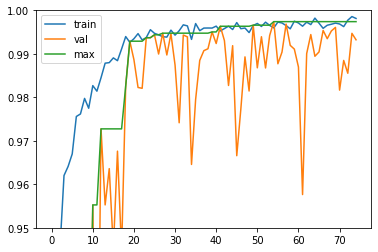

0.9974


In [20]:
metric = "_2"
df = pd.read_csv(path_results)
largest = [max(df["val_auc" + metric][:i+1]) for i in range(len(df))]
plt.plot(df["auc" + metric],label='train')
plt.plot(df["val_auc" + metric], label='val')
plt.plot(largest, label='max')
plt.legend()
plt.ylim(0.95,1)
plt.show()

auc = max(df["val_auc" + metric])
print(f"{auc:.4f}")

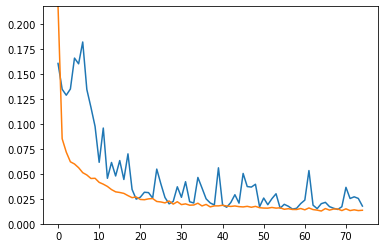

0.0144


In [21]:
plt.plot(df["val_loss"])
plt.plot(df["loss"])
plt.ylim(top=max(df["loss"]), bottom=0)
plt.show()
val_loss = min(df["val_loss"])
print(f"{val_loss:.4f}")